<a href="https://colab.research.google.com/github/GustavoTeofiloKotelak/Trabalho-De-Intelig-ncia-Artificial/blob/main/Trabalho_IA%2C_reconhecimento_o_HOMER_e_o_BART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

############## Importação das Bibliotecas ##############

In [1]:
import torch
import numpy as np
from torch import nn, optim

from torchvision import datasets, transforms

args = {
    'num_epochs' : 10,
    
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])

cpu


Construção do modelo, Redes neurais

In [2]:
# output = (input - filter + 1) / stride  A cada nova época você vai refinando seu modelo.
classificador = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size = 3), ## Kernel_size 3 é o operador de convolução, o filtro que sera usado na imagem, ## in_channels=3 Significa que serao usadas imagens em RGB
                              nn.ReLU(),                                                  ## Função de ativação linear retificada, é uma função linear por partes que produzirá a entrada diretamente se for positiva, caso contrário, produzirá zero.
                              nn.BatchNorm2d(num_features=32),                            ## Realiza uma normalização nas Camadas ocultas
                              # (64 - 3 + 1) / 1 = 62x62   Resultado do Filtro
                              nn.MaxPool2d(kernel_size = 2),                              ##Realiza um ajuste de resolução na imagem sem perder as características principais
                              # 31x31
                              nn.Conv2d(32, 32, 3),                                       ##Possivilita o aprendizado em duas dirções, altura e largura
                              nn.ReLU(),                                                  ## Função de ativação linear retificada
                              nn.BatchNorm2d(32),                                         ## Realiza uma normalização nas Camadas ocultas
                              # (31 - 3 + 1) / 1 = 29x29   Resultado do Filtro
                              nn.MaxPool2d(2),                                            ##Realiza um ajuste de resolução na imagem sem perder as características principais
                              #  14x14
                              nn.Flatten(),                                               ##Converte a matriz para um vetor
                              # 6272 -> 128 -> 128 -> 1    Resultado do Filtro
                              nn.Linear(in_features=14*14*32, out_features=128),          ##serão 6272 camadas de entradas conectadas em 128 neuronios 
                              nn.ReLU(),                                                  ## Função de ativação linear retificada
                              nn.Dropout(0.2),                                            ## 20% dos neuronios serao zerados
                              nn.Linear(128, 128),                                        ## A primeira camada oculta com 128 neuronio é ligada a uma segunda com 128 neuronios
                              nn.ReLU(),                                                  ## Função de ativação linear retificada
                              nn.Dropout(0.2),                                            ## 20% dos neuronios serao zerados
                              nn.Linear(128, 1),                                          ## A saída em binario ja que o algoritmo vai identificar caes ou gatos
                              nn.Sigmoid())                                               ## Retorna o valor da probabilidade

In [3]:
criterion = nn.BCELoss()                                                        ## Define o critério de perca
optimizer = optim.Adam(classificador.parameters())                              ## Adam é um algoritmo de otimização que pode ser usado em vez do procedimento estocástico clássico de gradiente descendente para atualizar pesos de rede de forma iterativa com base em dados de treinamento.

Permissão para o modelo pegar os dados direto do google drive

In [4]:
## Permite acessar a base de dados pelo google drive, viabilizando operar em nuvem
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
## Define a base para o treino e o teste
data_dir_train = '/content/drive/MyDrive/datasets/dataset_personagens/dataset_personagens/training_set'
data_dir_test = '/content/drive/MyDrive/datasets/dataset_personagens/dataset_personagens/test_set'

In [6]:
transform_train = transforms.Compose(
    [
     transforms.Resize([64, 64]),                                                           ## Transforma e redimensiona todas as imagens para o tamanho 64, 64
     transforms.RandomHorizontalFlip(),                                                     ## Transforam a imagem Horizontalmente
     transforms.RandomAffine(degrees=7, translate=(0, 0.07), shear=0.2, scale=(1, 1.2)),    ## Permite rotacionar a imagem
     transforms.ToTensor()                                                                  ## Transforma em Tensor
    ]
)

In [7]:
transform_test = transforms.Compose(
    [                               ### Menos transformações para se realizar os testes 
     transforms.Resize([64, 64]),   ## Transforma e redimensiona todas as imagens para o tamanho 64, 64
     transforms.ToTensor()          ## Transforma em Tensor
    ]
)

In [8]:
train_dataset = datasets.ImageFolder(data_dir_train, transform=transform_train)  ## Permite que as transformações ocorram em todas as imagens da base de treino

In [9]:
train_dataset   ## Ao imprimir o dataset do treino podemos ver algumas informações

Dataset ImageFolder
    Number of datapoints: 196
    Root location: /content/drive/MyDrive/datasets/dataset_personagens/dataset_personagens/training_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)  ## Realiza a transformação da base treino para 0 e 1

In [11]:
test_dataset = datasets.ImageFolder(data_dir_test, transform=transform_test)              ## Permite que as transformações ocorram em todas as imagens da base de teste

In [12]:
test_dataset  ## Ao imprimir o dataset do teste podemos ver algumas informações

Dataset ImageFolder
    Number of datapoints: 73
    Root location: /content/drive/MyDrive/datasets/dataset_personagens/dataset_personagens/test_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [13]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)     ## ## Realiza a transformação da base teste para 0 e 1

######################### Base de dados finalizada #########################

In [14]:
classificador.to(args['device']) ## Atribui o classificador para o device

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=6272, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=1, bias=True)
  (16): Sigmoid()
)

In [15]:
def training_loop(loader, epoch):                                               ## Define o Treino
    running_loss = 0.                                                           ## Calcula  o Erro
    running_accuracy = 0.                                                       ## Calcula a Acurácia
    
    for i, data in enumerate(loader):                                           ## Cria o loop de treinamento
        inputs, labels = data
        inputs, labels = inputs.to(args['device']), labels.to(args['device'])
        optimizer.zero_grad()                                                   ## Zera o Gradiente
        outputs = classificador(inputs)                                         ## Armazena os valores e retorna 1 (0 ou 1)
        
        loss = criterion(outputs, labels.float().view(*outputs.shape))          ## Calcula o erro
        loss.backward()
        
        optimizer.step()                                                        ##

        running_loss += loss.item()

        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(args['device']) ## Se o if for menor que 0.5 e imprime 1, caso contrário imprime 0
        
        equals = predicted == labels.view(*predicted.shape)
        
        accuracy = torch.mean(equals.float())                                   ## Faz o calculo da precisão
        running_accuracy += accuracy                                      
                   
        # Imprimindo os dados referentes a esse loop
        print('\rÉPOCA {:3d} - Loop {:3d} de {:3d}: perda {:03.2f}% - precisão {:03.2f}%'.format(epoch + 1, i + 1, len(loader), loss*100, (accuracy*100)), end = '\r')
        
    # Imprimindo os dados referentes a essa época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f}% - precisão {:.5f}%'.format(epoch + 1, running_loss/len(loader)*100, 
                    running_accuracy/len(loader)*100))

In [16]:
for epoch in range(args['num_epochs']):       ## Realiza o treinamento com o número de épocas definidas 
    print('Treinando...')                     ## Imprime "Treinando"
    training_loop(train_loader, epoch)        ## Realiza o treinamento de acordo com a base e as épocas definidas
    classificador.eval()                      ## Coloca o resultado em modo de avaliação
    print('Validando...')                     ## Imprime "Validando"
    training_loop(test_loader, epoch)         ## Realiza o teste de acordo com a base e as épocas definidas
    classificador.train()                     ## Coloca o resultado em modo de treinamento novamente

Treinando...
ÉPOCA   1 FINALIZADA: perda 61.10542% - precisão 61.60714%
Validando...
ÉPOCA   1 FINALIZADA: perda 67.35104% - precisão 83.21759%
Treinando...
ÉPOCA   2 FINALIZADA: perda 56.46831% - precisão 70.08929%
Validando...
ÉPOCA   2 FINALIZADA: perda 67.36973% - precisão 60.64815%
Treinando...
ÉPOCA   3 FINALIZADA: perda 36.87186% - precisão 83.03571%
Validando...
ÉPOCA   3 FINALIZADA: perda 71.46727% - precisão 47.10648%
Treinando...
ÉPOCA   4 FINALIZADA: perda 69.32447% - precisão 76.78571%
Validando...
ÉPOCA   4 FINALIZADA: perda 43.01480% - precisão 82.75463%
Treinando...
ÉPOCA   5 FINALIZADA: perda 43.68972% - precisão 83.03571%
Validando...
ÉPOCA   5 FINALIZADA: perda 32.10768% - precisão 86.34259%
Treinando...
ÉPOCA   6 FINALIZADA: perda 26.93608% - precisão 90.17857%
Validando...
ÉPOCA   6 FINALIZADA: perda 17.90741% - precisão 96.87500%
Treinando...
ÉPOCA   7 FINALIZADA: perda 20.88053% - precisão 94.64286%
Validando...
ÉPOCA   7 FINALIZADA: perda 9.20579% - precisão 97.

In [17]:
def classificar_imagem(fname):                                                  ## Define a Classificação da Imagem
  from PIL import Image                                                         ## Permite a visualização de imagem
  import matplotlib.pyplot as plt 
  imagem_teste = Image.open(data_dir_test + '/' + fname)                        ## Busca a imagem na base para fazer a leitura
  plt.imshow(imagem_teste)                                                      ## Carrega a imagem

  ## Pré-processa a imagem de teste
  import numpy as np
  imagem_teste = imagem_teste.resize((64, 64))                                    
  imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)  
  imagem_teste = imagem_teste / 255
  imagem_teste = imagem_teste.transpose(2, 0, 1)
  imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)

  ## Realiza a classificação das imagens
  classificador.eval()                                                          
  imagem_teste = imagem_teste.to(args['device'])
  output = classificador.forward(imagem_teste)
  if output > 0.5:
    output = 1
  else:
    output = 0
  print('Previsão: ', output)

  idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}  # Pega da propria Base o nome de Classificação Ex: Homer

  return idx_to_class[output]

Previsão:  0


'bart'

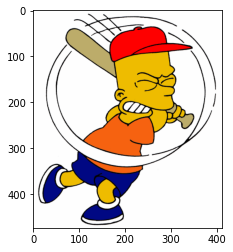

In [26]:
imagem = '/bart/bart15.bmp'    ## Define a imagem para testar os resultados 
classificar_imagem(imagem)    ## Classifica a imagem de acordo com o resultado do treinamento 

Previsão:  1


'homer'

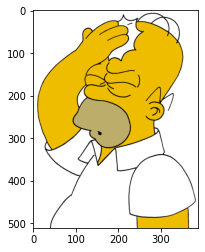

In [27]:
imagem = 'homer/homer2.bmp'      ## Define a imagem para testar os resultados 
classificar_imagem(imagem)       ## Classifica a imagem de acordo com o resultado do treinamento 